Plan: 
1. Compare normal to spread spectrum with averages over testing set and plot results
2. Fine tune rho parameter using average over testing set for spread spectrum and plot results
3. Run for different tolerances and plot results

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import tqdm
import skimage.metrics as metrics
from PIL import Image
import os

from M1 import create_mask, create_meas_op, create_spread_spectrum_meas_op, gen_noise, gen_sparsity_op, admm_conbpdn, rsnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
def run_admm(img_file, spread_spectrum=False, rho=1e2, rel_tol=1e-4, rel_tol2=1e-4, max_iter=200):
    img = np.array(Image.open(img_file)).astype(np.float32)
    img = torch.tensor(img, dtype=torch.float32, device=device)

    # Create a Fourier mask
    mask = create_mask(*img.shape).to(device)
    
    # Apply spread spectrum if required
    if spread_spectrum:
        # Create diagonal spread spectrum matrix D and measurement operators
        D = 2 * (torch.rand(*img.shape, device=device).T < 0.5).to(dtype=img.dtype) - 1
        Phit, Phi = create_spread_spectrum_meas_op(mask, D)
    else:
        Phit, Phi = create_meas_op(mask)

    # Compute the measurements with forward measurement operator Phit
    y0 = Phit(img)

    # Compute noise given the image, mask, and iSNR
    noise, sigma = gen_noise(img, mask)

    # Add the noise to the measurements
    y = y0 + noise
    M = y.numel()

    # Generate the sparsity operator
    Psit, Psi = gen_sparsity_op()

    # Get backprojected image
    y_bp = Phi(y)

    # For imposing the constraint on the data-fidelity term, you will use
    # following value of the epsilon parameter.
    epsilon = sigma * np.sqrt(M + 2 * np.sqrt(M))

    # Reconstruct the image by calling our ADMM implementation
    xsol, fval, it = admm_conbpdn(
        y,
        epsilon,
        Phit,
        Phi,
        Psit,
        Psi,
        verbose=0,
        rel_tol=rel_tol,
        rel_tol2=rel_tol2,
        max_iter=max_iter,
        rho=rho,
        delta=1.0,
    )

    # Calculate SNR and SSIM of the reconstructed image
    snr = rsnr(xsol.cpu().numpy(), img.cpu().numpy())
    ssim = metrics.structural_similarity(img.cpu().numpy(), xsol.cpu().numpy(), data_range=(img.max() - img.min()).item())

    return xsol, y_bp, snr, ssim

In [4]:
# Load the testing set images
testing_set_dir = "../testing_set"
if not os.path.isdir(testing_set_dir):
    raise FileNotFoundError(f"Testing set directory not found: {testing_set_dir}")
testing_files = [os.path.join(testing_set_dir, f) for f in os.listdir(testing_set_dir)]

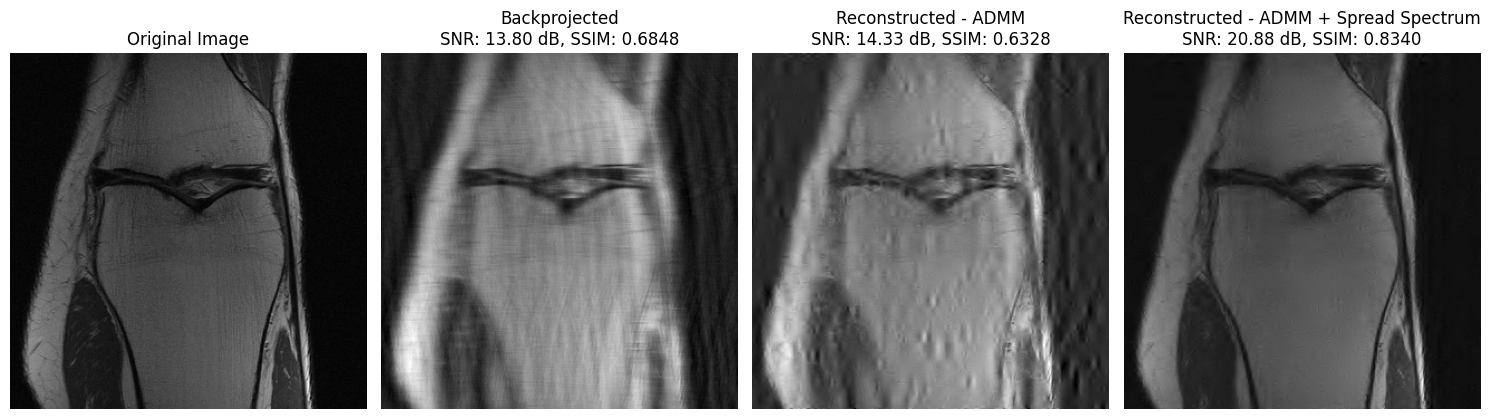

In [5]:
# Visualize original, backprojected, and reconstructed images for the first test image
img_file = testing_files[0]

# Load the original image
img = np.array(Image.open(img_file)).astype(np.float32)
img_torch = torch.tensor(img, dtype=torch.float32, device=device)

# Reconstruct using ADMM
xsol, y_bp, snr_reconstructed, ssim_reconstructed = run_admm(img_file, spread_spectrum=False, rho=10)

# Reconstruct using ADMM with spread spectrum
xsol_ss, _, snr_reconstructed_ss, ssim_reconstructed_ss = run_admm(img_file, spread_spectrum=True, rho=10)

# Calculate SNR for backprojected image
snr_backprojected = rsnr(y_bp.cpu().numpy(), img)
ssim_backprojected = metrics.structural_similarity(img, y_bp.cpu().numpy(), data_range=img.max() - img.min())

# Plot side by side
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(y_bp.cpu().numpy(), cmap='gray')
axes[1].set_title(f'Backprojected\nSNR: {snr_backprojected:.2f} dB, SSIM: {ssim_backprojected:.4f}')
axes[1].axis('off')

axes[2].imshow(xsol.cpu().numpy(), cmap='gray')
axes[2].set_title(f'Reconstructed - ADMM\nSNR: {snr_reconstructed:.2f} dB, SSIM: {ssim_reconstructed:.4f}')
axes[2].axis('off')

axes[3].imshow(xsol_ss.cpu().numpy(), cmap='gray')
axes[3].set_title(f'Reconstructed - ADMM + Spread Spectrum\nSNR: {snr_reconstructed_ss:.2f} dB, SSIM: {ssim_reconstructed_ss:.4f}')
axes[3].axis('off')

plt.tight_layout()
plt.show()

Comparing ADMM with and without spread spectrum...


Processing test images: 100%|██████████| 20/20 [01:09<00:00,  3.50s/img]


Results:
Without Spread Spectrum - SNR: 17.06 dB, SSIM: 0.7013
With Spread Spectrum    - SNR: 20.65 dB, SSIM: 0.8097


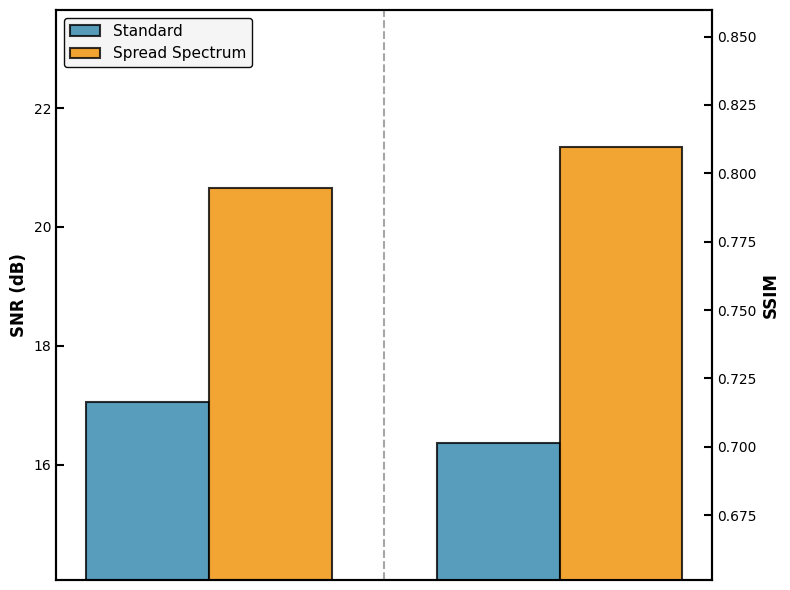

In [14]:
# Compare ADMM with and without spread spectrum
print("Comparing ADMM with and without spread spectrum...")

# Initialize lists to store results
snr_no_ss = []
ssim_no_ss = []
snr_with_ss = []
ssim_with_ss = []

# Loop through all test images
for img_file in tqdm.tqdm(testing_files, desc="Processing test images", unit="img"):
    # Without spread spectrum
    xsol, _, snr, ssim = run_admm(img_file, spread_spectrum=False, rho=10)
    snr_no_ss.append(snr)
    ssim_no_ss.append(ssim)
    
    # With spread spectrum
    xsol_ss, _, snr_ss, ssim_ss = run_admm(img_file, spread_spectrum=True, rho=10)
    snr_with_ss.append(snr_ss)
    ssim_with_ss.append(ssim_ss)

# Calculate averages
avg_snr_no_ss = np.mean(snr_no_ss)
avg_ssim_no_ss = np.mean(ssim_no_ss)
avg_snr_with_ss = np.mean(snr_with_ss)
avg_ssim_with_ss = np.mean(ssim_with_ss)

print(f"\nResults:")
print(f"Without Spread Spectrum - SNR: {avg_snr_no_ss:.2f} dB, SSIM: {avg_ssim_no_ss:.4f}")
print(f"With Spread Spectrum    - SNR: {avg_snr_with_ss:.2f} dB, SSIM: {avg_ssim_with_ss:.4f}")

# Apply plot styling function
def apply_plot_style(ax, show_legend=False):
    """Apply consistent styling to a plot axis"""
    ax.grid(False)
    ax.set_facecolor('white')
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    
    ax.tick_params(direction='in', length=6, width=1.5, colors='black',
                   which='both', top=True, right=True)

# Create grouped bar chart with dual y-axes
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.patch.set_facecolor('white')

# X-axis positions for SNR and SSIM
x = np.arange(2)
width = 0.35

# SNR bars (left side)
snr_standard = avg_snr_no_ss
snr_ss = avg_snr_with_ss

# Plot SNR bars at position 0
ax1.bar(x[0] - width/2, snr_standard, width, 
        color='#2E86AB', edgecolor='black', linewidth=1.5, 
        alpha=0.8, label='Standard')
ax1.bar(x[0] + width/2, snr_ss, width, 
        color='#F18F01', edgecolor='black', linewidth=1.5, 
        alpha=0.8, label='Spread Spectrum')

# Configure left y-axis for SNR
ax1.set_ylabel('SNR (dB)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black')

# Create second y-axis for SSIM
ax2 = ax1.twinx()

# SSIM bars (right side)
ssim_standard = avg_ssim_no_ss
ssim_ss = avg_ssim_with_ss

# Plot SSIM bars at position 1
ax2.bar(x[1] - width/2, ssim_standard, width, 
        color='#2E86AB', edgecolor='black', linewidth=1.5, 
        alpha=0.8)
ax2.bar(x[1] + width/2, ssim_ss, width, 
        color='#F18F01', edgecolor='black', linewidth=1.5, 
        alpha=0.8)

# Configure right y-axis for SSIM
ax2.set_ylabel('SSIM', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black')

# Remove x-axis ticks and labels
ax1.set_xticks([])
ax1.set_xticklabels([])
ax2.set_xticks([])
ax2.set_xticklabels([])

# Add dashed line through the middle
ax1.axvline(x=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# Apply styling to ax1 (left axis)
ax1.grid(False)
ax1.set_facecolor('white')
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
ax1.tick_params(direction='in', length=6, width=1.5, colors='black',
                which='both', top=True, right=False, left=True, labelleft=True, labelright=False)

# Apply styling to ax2 (right axis)
ax2.grid(False)
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
ax2.tick_params(direction='in', length=6, width=1.5, colors='black',
                which='both', top=True, right=True, left=False, labelright=True, labelleft=False)

# Adjust y limits according to min/max values
ax1.set_ylim(min(snr_standard, snr_ss) - 3, max(snr_standard, snr_ss) + 3)
ax2.set_ylim(min(ssim_standard, ssim_ss) - 0.05, max(ssim_standard, ssim_ss) + 0.05)

# Add legend
ax1.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, 
           framealpha=0.95, edgecolor='black', facecolor='#f5f5f5')

plt.tight_layout()
plt.show()

Testing different rho values for spread spectrum ADMM...

Running ADMM with rho = 1


Processing (rho=1): 100%|██████████| 20/20 [01:41<00:00,  5.09s/img]



Running ADMM with rho = 5


Processing (rho=5): 100%|██████████| 20/20 [00:33<00:00,  1.67s/img]



Running ADMM with rho = 10


Processing (rho=10): 100%|██████████| 20/20 [00:24<00:00,  1.22s/img]



Running ADMM with rho = 15


Processing (rho=15): 100%|██████████| 20/20 [00:21<00:00,  1.10s/img]



Running ADMM with rho = 20


Processing (rho=20): 100%|██████████| 20/20 [00:23<00:00,  1.17s/img]



Running ADMM with rho = 25


Processing (rho=25): 100%|██████████| 20/20 [00:23<00:00,  1.20s/img]



Running ADMM with rho = 30


Processing (rho=30): 100%|██████████| 20/20 [00:25<00:00,  1.29s/img]



Running ADMM with rho = 35


Processing (rho=35): 100%|██████████| 20/20 [00:28<00:00,  1.45s/img]



Running ADMM with rho = 40


Processing (rho=40): 100%|██████████| 20/20 [00:33<00:00,  1.69s/img]



Running ADMM with rho = 45


Processing (rho=45): 100%|██████████| 20/20 [00:34<00:00,  1.72s/img]



Running ADMM with rho = 50


Processing (rho=50): 100%|██████████| 20/20 [00:38<00:00,  1.93s/img]



Running ADMM with rho = 55


Processing (rho=55): 100%|██████████| 20/20 [00:41<00:00,  2.05s/img]



Running ADMM with rho = 60


Processing (rho=60): 100%|██████████| 20/20 [00:47<00:00,  2.39s/img]



Running ADMM with rho = 65


Processing (rho=65): 100%|██████████| 20/20 [00:48<00:00,  2.43s/img]



Running ADMM with rho = 70


Processing (rho=70): 100%|██████████| 20/20 [00:49<00:00,  2.50s/img]



Running ADMM with rho = 75


Processing (rho=75): 100%|██████████| 20/20 [00:53<00:00,  2.66s/img]



Running ADMM with rho = 80


Processing (rho=80): 100%|██████████| 20/20 [00:57<00:00,  2.87s/img]



Running ADMM with rho = 85


Processing (rho=85): 100%|██████████| 20/20 [00:59<00:00,  2.98s/img]



Running ADMM with rho = 90


Processing (rho=90): 100%|██████████| 20/20 [01:04<00:00,  3.22s/img]



Running ADMM with rho = 95


Processing (rho=95): 100%|██████████| 20/20 [01:09<00:00,  3.45s/img]



Running ADMM with rho = 100


Processing (rho=100): 100%|██████████| 20/20 [01:08<00:00,  3.41s/img]


Completed rho sweep!


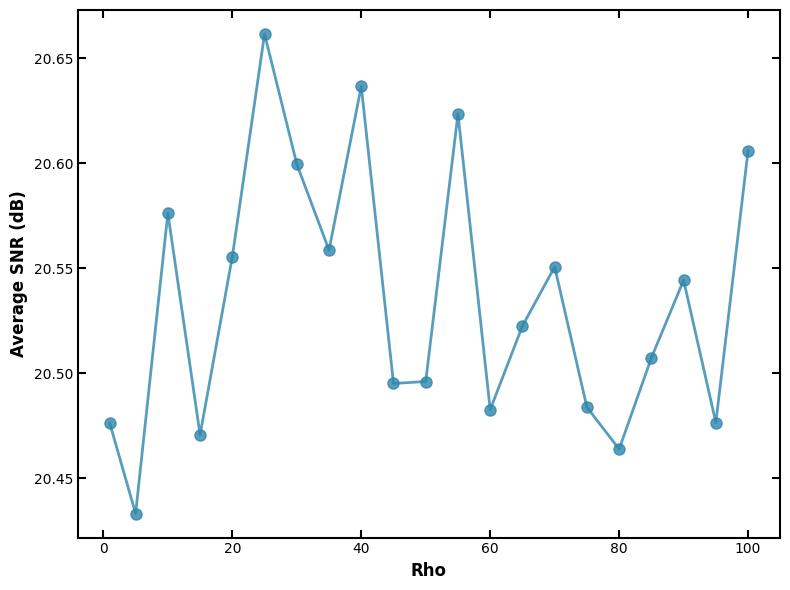

In [26]:
# Fine-tune rho parameter for spread spectrum variant
print("Testing different rho values for spread spectrum ADMM...")

# Initialize lists to store overall SNR and SSIM results
overall_snr_list = []
overall_ssim_list = []

# Define rho values to test
rho_values = [1] + list(range(5, 101, 5))

# Loop through multiple rho values
for rho in rho_values:
    print(f"\nRunning ADMM with rho = {rho}")

    # Initialize lists to store per run results
    snr_list = []
    ssim_list = []

    # Loop through all images in the testing set with a progress bar
    for img_file in tqdm.tqdm(testing_files, desc=f"Processing (rho={rho})", unit="img"):
        xsol, _, snr, ssim = run_admm(img_file, spread_spectrum=True, rho=rho)

        # Append results to the lists
        snr_list.append(snr)
        ssim_list.append(ssim)

    # Store average SNR and SSIM
    overall_snr_list.append(np.mean(snr_list))
    overall_ssim_list.append(np.mean(ssim_list))

print(f"\nCompleted rho sweep!")

# Create plot for SNR vs Rho
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.patch.set_facecolor('white')

# Plot SNR
ax.plot(rho_values, overall_snr_list, marker='o', color='#2E86AB', 
        linewidth=2, markersize=8, alpha=0.8)
ax.set_xlabel('Rho', fontsize=12, fontweight='bold')
ax.set_ylabel('Average SNR (dB)', fontsize=12, fontweight='bold')

# Apply styling
apply_plot_style(ax)

plt.tight_layout()
plt.show()

Testing different tolerance values for spread spectrum ADMM...

Running ADMM with rel_tol = rel_tol2 = 0.01


Processing (tol=0.01): 100%|██████████| 20/20 [00:12<00:00,  1.55img/s]



Running ADMM with rel_tol = rel_tol2 = 0.005


Processing (tol=0.005): 100%|██████████| 20/20 [00:13<00:00,  1.48img/s]



Running ADMM with rel_tol = rel_tol2 = 0.001


Processing (tol=0.001): 100%|██████████| 20/20 [00:16<00:00,  1.19img/s]



Running ADMM with rel_tol = rel_tol2 = 0.0005


Processing (tol=0.0005): 100%|██████████| 20/20 [00:16<00:00,  1.24img/s]



Running ADMM with rel_tol = rel_tol2 = 0.0001


Processing (tol=0.0001): 100%|██████████| 20/20 [00:20<00:00,  1.00s/img]



Running ADMM with rel_tol = rel_tol2 = 5e-05


Processing (tol=5e-05): 100%|██████████| 20/20 [00:24<00:00,  1.22s/img]



Running ADMM with rel_tol = rel_tol2 = 1e-05


Processing (tol=1e-05): 100%|██████████| 20/20 [00:36<00:00,  1.81s/img]



Running ADMM with rel_tol = rel_tol2 = 5e-06


Processing (tol=5e-06): 100%|██████████| 20/20 [00:35<00:00,  1.75s/img]



Running ADMM with rel_tol = rel_tol2 = 1e-06


Processing (tol=1e-06): 100%|██████████| 20/20 [00:39<00:00,  1.95s/img]


Completed tolerance sweep!


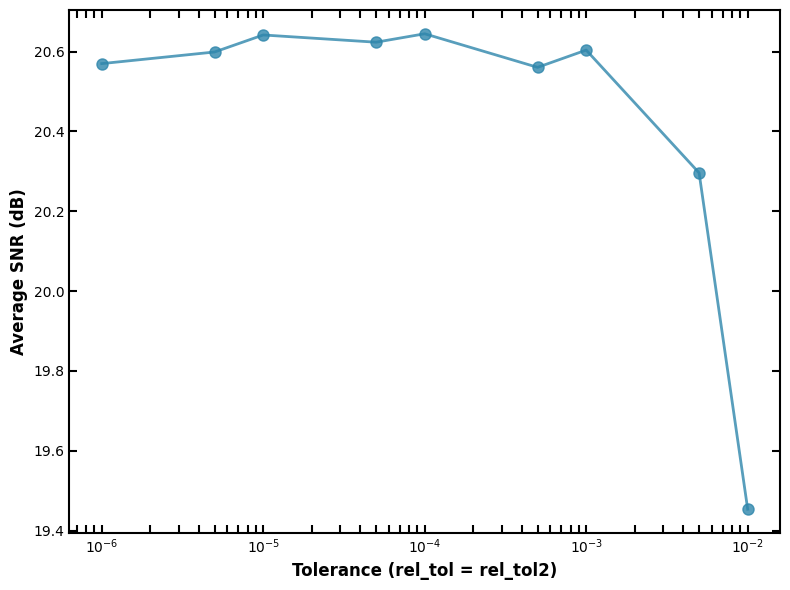

In [27]:
# Test different tolerance values for spread spectrum variant
print("Testing different tolerance values for spread spectrum ADMM...")

# Initialize lists to store overall SNR results
overall_snr_tol_list = []

# Define tolerance values to test
tolerance_values = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]

# Loop through multiple tolerance values
for tol in tolerance_values:
    print(f"\nRunning ADMM with rel_tol = rel_tol2 = {tol}")

    # Initialize lists to store per run results
    snr_list = []

    # Loop through all images in the testing set with a progress bar
    for img_file in tqdm.tqdm(testing_files, desc=f"Processing (tol={tol})", unit="img"):
        xsol, _, snr, ssim = run_admm(img_file, spread_spectrum=True, rho=25, 
                                      rel_tol=tol, rel_tol2=tol, max_iter=10000)

        # Append results to the lists
        snr_list.append(snr)

    # Store average SNR
    overall_snr_tol_list.append(np.mean(snr_list))

print(f"\nCompleted tolerance sweep!")

# Create plot for SNR vs Tolerance
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.patch.set_facecolor('white')

# Plot SNR
ax.plot(tolerance_values, overall_snr_tol_list, marker='o', color='#2E86AB', 
        linewidth=2, markersize=8, alpha=0.8)
ax.set_xlabel('Tolerance (rel_tol = rel_tol2)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average SNR (dB)', fontsize=12, fontweight='bold')
ax.set_xscale('log')

# Apply styling
apply_plot_style(ax)

plt.tight_layout()
plt.show()